# Airbnb Paris listing price prediction

Over here I try to explore Airbnb listing price, and predict their price using various machine learning models. 


The Airbnb listing price depends on various factor associated with the listing. The price of a particular listing also has a seasonal trend. The prices are usually higher over weekends, and in peak travel time like Christmas, New Years and other long weekends. Here, I looked predicting price of an Airbnb listing from its feature using maching leanring. At the same time, explore the Airbnb data to understand some underlying features in Airbnb listing.

I download the Airbnb listing price data for Paris, France from [Inside Airbnb](http://insideairbnb.com/get-the-data.html). This has a snapshot of listings available on a single data at 09 October 2018.

I chose Paris because it has the highest number of listing for a city in Inside Airbnb. 

Source of data: http://insideairbnb.com/get-the-data.html

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.simplefilter('ignore')
import scipy.stats as stats
import time

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, r2_score, median_absolute_error
from sklearn import linear_model, ensemble
from sklearn.model_selection import GridSearchCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.base import clone
import xgboost

%matplotlib inline

## Listing Data

The listing data contains 96 features for each of the 4984 listing in Denver, CO region.  

In [2]:
file_listing = '../data/listings_paris.csv.gz'
listing = pd.read_csv(file_listing)
og_len = listing.shape[0]
print('Number of entries: {:d}'.format(og_len))
print('Number of columns: {:d}'.format(listing.shape[1]))
print('The columns are:')
listing.columns

Number of entries: 61223
Number of columns: 96
The columns are:


Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms',

### Columns of interest:

There are too many columns in the original data set, which are not relevant to the task. So I trim the dataset to the interesting columns that I care about. 

Interesting columns:
1. id:  
2. host_response_time:  
3. host_response_rate:  
4. host_acceptance_rate:  
5. host_is_superhost:  
6. host_listings_count:  
7. host_identity_verified:  
8. neighbourhood_cleansed:  
9. property_type:  
10. room_type:  
11. accommodates:  
12. bathrooms:  
13. bedrooms:  
14. beds':  
15. bed_type:  
16. square_feet:  
17. price:  
18. security_deposit:  
19. cleaning_fee:   
20. number_of_reviews:  
21. review_scores_rating:  
22. review_scores_accuracy:  
23. review_scores_cleanliness:  
24. review_scores_checkin:  
25. review_scores_communication:  
26. review_scores_location:  
27. review_scores_value:  
28. instant_bookable:  
29. is_business_travel_ready:  
30. cancellation_policy:  
31. require_guest_profile_picture:  
32. require_guest_phone_verification:  
33. reviews_per_month:  

In [3]:
columns = ['id','host_response_time', 'host_response_rate',
           'host_acceptance_rate', 'host_is_superhost', 'host_listings_count',
           'host_identity_verified', 'neighbourhood_cleansed', 'property_type', 
           'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 
           'bed_type', 'square_feet', 'price', 'security_deposit', 'cleaning_fee', 
           'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy', 
           'review_scores_cleanliness', 'review_scores_checkin', 
           'review_scores_communication', 'review_scores_location', 
           'review_scores_value', 'instant_bookable', 'is_business_travel_ready', 
           'cancellation_policy', 'require_guest_profile_picture', 
           'require_guest_phone_verification', 'reviews_per_month']

listing = listing[columns]

# Brief look at the data
listing.head()

,id,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_identity_verified,neighbourhood_cleansed,property_type,room_type,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month
0,3109,NaN,NaN,NaN,f,1.0,f,Observatoire,Apartment,Entire home/apt,...,10.0,10.0,10.0,10.0,f,f,flexible,f,f,0.32
1,5396,within an hour,100%,NaN,f,1.0,t,Hôtel-de-Ville,Apartment,Entire home/apt,...,10.0,10.0,10.0,10.0,t,f,strict_14_with_grace_period,f,f,1.25
2,75922,within an hour,100%,NaN,f,3.0,t,Temple,Apartment,Entire home/apt,...,9.0,9.0,10.0,9.0,t,f,strict_14_with_grace_period,f,f,0.18
3,7397,within an hour,100%,NaN,t,1.0,t,Hôtel-de-Ville,Apartment,Entire home/apt,...,10.0,10.0,10.0,9.0,f,f,moderate,f,f,2.46
4,76348,NaN,NaN,NaN,f,1.0,f,Gobelins,Apartment,Private room,...,9.0,9.0,9.0,9.0,f,f,moderate,f,f,0.39


### Data types in columns

In [4]:
listing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61223 entries, 0 to 61222
Data columns (total 33 columns):
id                                  61223 non-null int64
host_response_time                  28599 non-null object
host_response_rate                  28599 non-null object
host_acceptance_rate                0 non-null float64
host_is_superhost                   61210 non-null object
host_listings_count                 61210 non-null float64
host_identity_verified              61210 non-null object
neighbourhood_cleansed              61223 non-null object
property_type                       61223 non-null object
room_type                           61223 non-null object
accommodates                        61223 non-null int64
bathrooms                           61139 non-null float64
bedrooms                            61143 non-null float64
beds                                60987 non-null float64
bed_type                            61223 non-null object
square_feet           

## Data Cleaning

### Format dtypes
1. Convert 'host_response_rate' to float.  
2. Make host_is_superhost, host_identity_verified, instant_bookable, is_business_travel_ready, require_guest_profile_picture, and require_guest_phone_verification to a binary variable.  
3. Format price, security_deposity and cleaning_fee to float.  

In [5]:
# 'host_response_rate' to float
listing['host_response_rate'] = listing['host_response_rate'].replace(
                                    '[\%,]', '', regex=True).astype(float)

# Make host_is_superhost, host_identity_verified, instant_bookable, 
# is_business_travel_ready, require_guest_profile_picture, 
# and require_guest_phone_verification to binary variable
listing = listing.replace({'host_is_superhost':{'t':1, 'f':0},
                          'host_identity_verified':{'t':1, 'f':0},
                          'instant_bookable':{'t':1, 'f':0},
                          'is_business_travel_ready':{'t':1, 'f':0},
                          'require_guest_profile_picture':{'t':1, 'f':0},
                          'require_guest_phone_verification':{'t':1, 'f':0}})

# Format price, security_deposity and cleaning_fee to float
columns = ['price', 'security_deposit', 'cleaning_fee']
listing[columns] = listing[columns].replace(
                                '[\$,]', '', regex=True).astype(float)



### Missing entries

Count the number of missing entry in each column

In [6]:
print('Number of entries is {0:d} '.format(listing.shape[0]))

listing.isnull().sum()

Number of entries is 61223 


id                                      0
host_response_time                  32624
host_response_rate                  32624
host_acceptance_rate                61223
host_is_superhost                      13
host_listings_count                    13
host_identity_verified                 13
neighbourhood_cleansed                  0
property_type                           0
room_type                               0
accommodates                            0
bathrooms                              84
bedrooms                               80
beds                                  236
bed_type                                0
square_feet                         59770
price                                   0
security_deposit                    19546
cleaning_fee                        17224
number_of_reviews                       0
review_scores_rating                13456
review_scores_accuracy              13527
review_scores_cleanliness           13507
review_scores_checkin             

### Handle missing data

#### Drp columns with too much missing data

Columns to be dropped: 'square_feet' and 'host_acceptance_rate'

In [7]:
listing = listing.drop(columns=['square_feet', 'host_acceptance_rate'])

#### host_response_time
Replace null for hosts that don't respond to No replies

In [8]:
listing = listing.fillna(value={'host_response_time': 'No replies'})
listing['host_response_time'].value_counts()

No replies            32624
within an hour        14854
within a few hours     6555
within a day           6096
a few days or more     1094
Name: host_response_time, dtype: int64

#### host_response_rate 

Bin into high response rate, low response rate and no replies categorical labesl

No replies            33429
high response rate    24063
low response rate      3731
Name: host_response_rate, dtype: int64

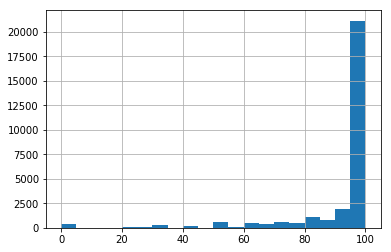

In [9]:
listing['host_response_rate'].hist(bins=20)

def bucket_response_rate(x):
    if x > 80:
        return 'high response rate'
    elif x<80:
        return 'low response rate'
    else:
        return 'No replies'
listing['host_response_rate'] = listing['host_response_rate'].apply(bucket_response_rate)
listing['host_response_rate'].value_counts()

#### Security_deposit and cleaning_fee

Set null to zero

In [10]:
listing = listing.fillna(value={'security_deposit':0, 'cleaning_fee':0})

#### Review columns
It seems that new listings don't have reviews yet. I would rather remove them from the analysis becaue we can't be sure that the hosts have listed an appropriate price for their listing. Once a property has been reviewed for some time we get information from the market if it is appropriate prices.

#### Remove rows with missing entries
So lets go ahead and just remove all the entries with missing values

In [11]:
listing = listing.dropna()

### Summary

We can see that we have lost 13767 or 22.5% of data. We still have about 47k entries, which should be more than enough to make predictions.

In [12]:
print('Orginial Number of entries: {:d}'.format(og_len))
print('Number of entries after data cleaing: {:d}'.format(listing.shape[0]))
lost_entries = og_len - listing.shape[0]
lost_entries_per = lost_entries/og_len*100
print('Number of entires lost: {:d} or {:.1f}%'.format(lost_entries, lost_entries_per))

Orginial Number of entries: 61223
Number of entries after data cleaing: 47456
Number of entires lost: 13767 or 22.5%


## Data Exploration

Trying to look at some general trends and structure in the data. While also gaining some insight into the data

##### Number of apartments vs accomodates

We can observe that apartments with accomodates of multiple of two are more popular. I would guess that this is because most listing would use a standard bed which accommodates two people. So the number of accommodates goes along with it. And fewer apartments have bed/couch for single person. 

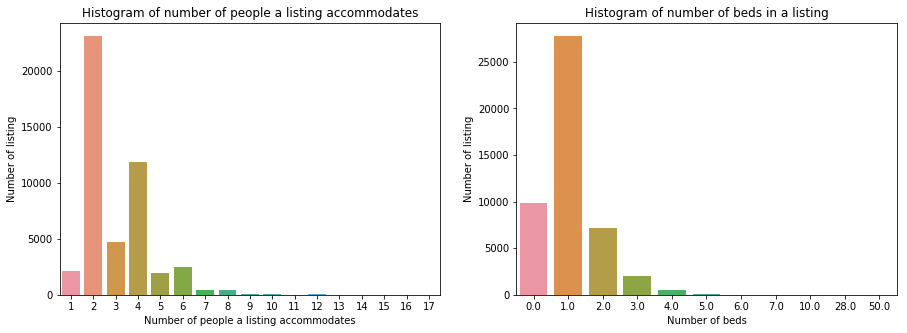

In [13]:
f, axs = plt.subplots(1,2,figsize=(15,5));

# Subplot 1 (Error in eigen_value)
sns.countplot(x='accommodates', data=listing, ax=axs[0])
axs[0].set_title('Histogram of number of people a listing accommodates')
axs[0].set_xlabel('Number of people a listing accommodates')
axs[0].set_ylabel('Number of listing')

# # Subplot 2 (Error in eigen_ec)
sns.countplot(x='bedrooms', data=listing, ax=axs[1])
axs[1].set_title('Histogram of number of beds in a listing')
axs[1].set_xlabel('Number of beds')
axs[1].set_ylabel('Number of listing');

#### Histogram of number of bathrooms

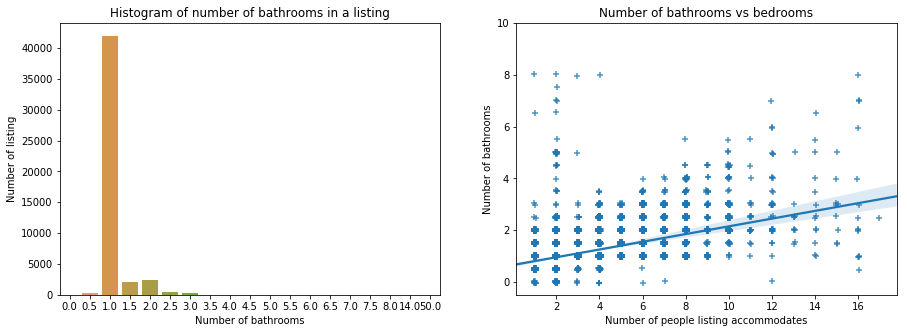

In [14]:
f, axs = plt.subplots(1,2,figsize=(15,5));

# Subplot 1 (Error in eigen_value)
sns.countplot(x='bathrooms', data=listing, ax=axs[0])
axs[0].set_title('Histogram of number of bathrooms in a listing')
axs[0].set_xlabel('Number of bathrooms')
axs[0].set_ylabel('Number of listing')

# # Subplot 2 (Error in eigen_ec)
sns.regplot(x='accommodates', y='bathrooms', data=listing, ax=axs[1], marker='+', x_jitter=0.05, y_jitter=0.05)
axs[1].set_title('Number of bathrooms vs bedrooms')
axs[1].set_xlabel('Number of people listing accommodates')
axs[1].set_ylabel('Number of bathrooms')
axs[1].set_ylim([-0.5, 10]);

#### Price distribution

- Price is a function of number of people or number of bed in an apartment. So will fix each quantity and see how the price varies.

- Per person decreases slightly till the number of person a house accommodates increases till 3, after there isn't a significant difference in the price. 

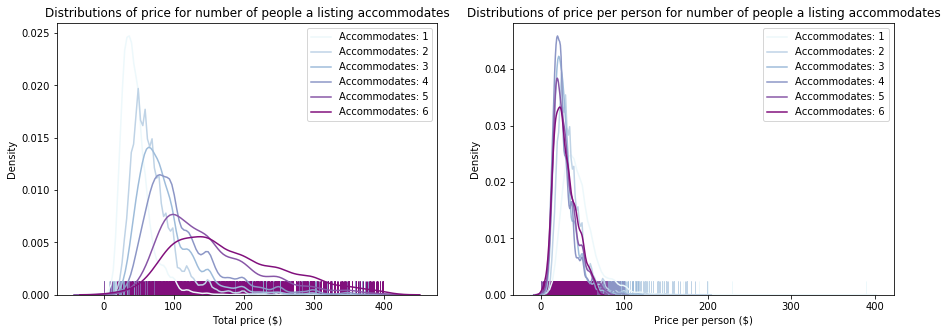

In [15]:
colors = ['#edf8fb', '#bfd3e6', '#9ebcda', '#8c96c6', '#8856a7', '#810f7c']


f, axs = plt.subplots(1,2,figsize=(15,5));

# Subplot 1 (Error in eigen_value)
for no_people in range(1,7):
    sns.distplot(listing[(listing['price']<400) & (listing['accommodates'] == no_people)]['price'],
                 bins=30, kde=True, hist=False, rug=True, label='Accommodates: {:d}'.format(no_people), 
                 ax=axs[0], color=colors[no_people-1])
axs[0].set_title('Distributions of price for number of people a listing accommodates')
axs[0].set_xlabel('Total price ($)')
axs[0].set_ylabel('Density')

# # Subplot 2 (Error in eigen_ec)

for no_people in range(1,7):
    sns.distplot(listing[(listing['price']<400) & (listing['accommodates'] == no_people)]['price']/no_people,
                 bins=30, kde=True, hist=False, rug=True, label='Accommodates: {:d}'.format(no_people), 
                 ax=axs[1], color=colors[no_people-1])
axs[1].set_title('Distributions of price per person for number of people a listing accommodates')
axs[1].set_xlabel('Price per person ($)')
axs[1].set_ylabel('Density');

#### Numeric quantities correlating with price


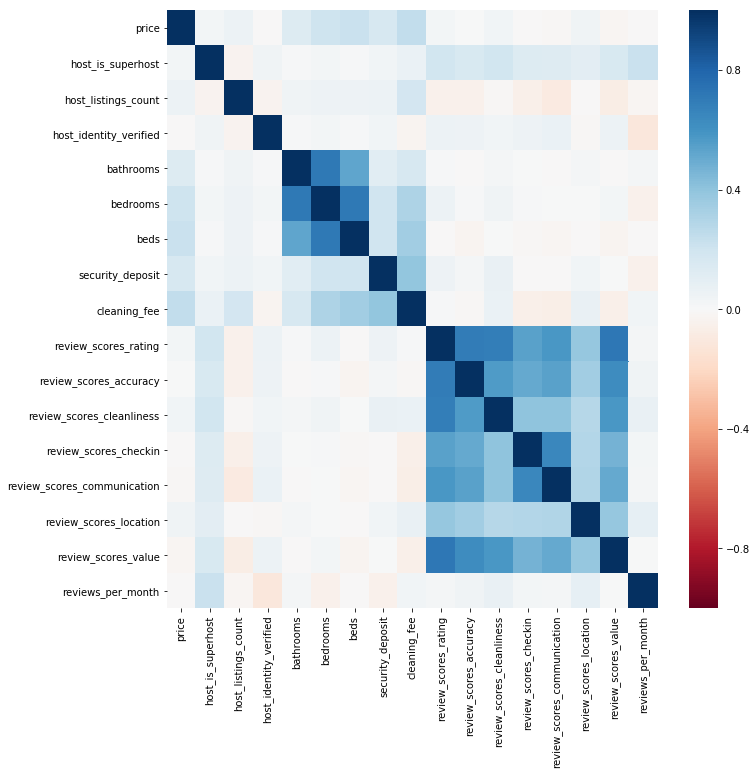

In [16]:
select_columns = ['price', 'host_is_superhost', 'host_listings_count', 
                'host_identity_verified', 'bathrooms', 'bedrooms', 'beds', 'security_deposit', 
                'cleaning_fee', 'review_scores_rating', 'review_scores_accuracy', 
                'review_scores_cleanliness', 'review_scores_checkin', 
                'review_scores_communication', 'review_scores_location', 
                 'review_scores_value', 'reviews_per_month']
corrmat = listing[select_columns].corr()
plt.figure(figsize=(11,11))
sns.heatmap(corrmat, vmin=-1, vmax=1, cmap="RdBu");

## Feature Engineering

### Target variable

Price is the target variable. We will add the cleaning fee to the price and remove security deposity from the analysis

We can see that price has some outliers. We will just remove all the price entries with value greater than 500 and equal to 0.

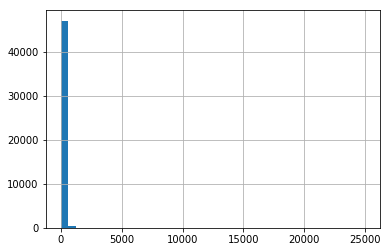

In [17]:
listing['price'] = listing['price'] + listing['cleaning_fee']
listing = listing.drop(['cleaning_fee', 'security_deposit'], axis=1)

listing['price'].hist(bins=40)
listing = listing[listing['price']<500]
listing = listing[listing['price']>0]

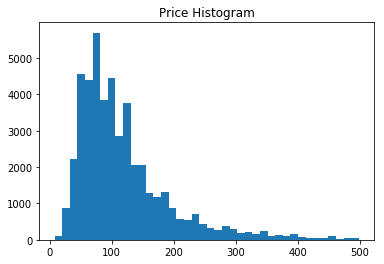

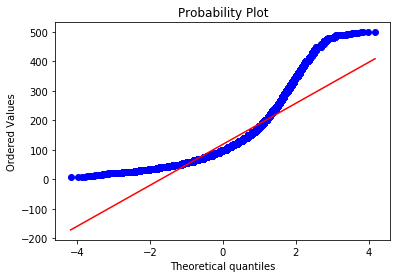

In [18]:
plt.figure()
plt.hist(listing['price'], bins=40)
plt.title('Price Histogram')

plt.figure()
stats.probplot(listing['price'], dist="norm", plot=plt)
plt.show()

The price distribution is skewed so we will apply log-transformation to fix it

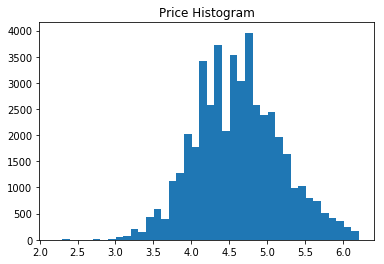

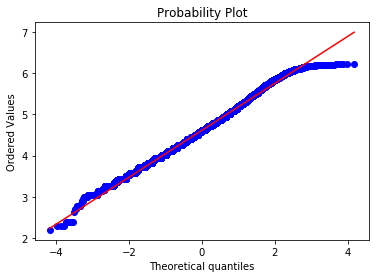

In [19]:
listing['log_price'] = listing['price'].apply(lambda x: np.log(x + 1))

plt.figure()
plt.hist(listing['log_price'], bins=40)
plt.title('Price Histogram')

plt.figure()
stats.probplot(listing['log_price'], dist="norm", plot=plt)
plt.show()

##### Split target variable

In [20]:
Y = listing['log_price']
X = listing.drop(['log_price', 'price', 'id'], axis=1)

### Encode categorical variables

1. Binary categorical features: Leave as is
2. Mutli-level categorical features: Conver to on-hot encoding or drop them 

In [21]:
multi_level_cat_columns = ['host_response_time', 'host_response_rate',
        'neighbourhood_cleansed', 'property_type', 'room_type',
        'bed_type', 'cancellation_policy']
og_columns = X.shape[1]
X = pd.get_dummies(X, columns=multi_level_cat_columns)
print('Number of columns increased from {:d} to {:d}'.format(og_columns, X.shape[1]))

Number of columns increased from 27 to 89


### Transform numerical features

Won't transform the values now. Will only define the numerical columns that need to be transformed.

In [22]:
num_columns = ['host_listings_count', 'accommodates', 'bathrooms', 
               'bedrooms', 'beds', 'number_of_reviews', 'review_scores_rating',
              'review_scores_accuracy', 'review_scores_cleanliness',
              'review_scores_checkin', 'review_scores_communication',
              'review_scores_location', 'review_scores_value', 'reviews_per_month']

# Modeling

### Split train and test

We split the data into training and test set with a split ratio of 80:20. 

In [23]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,test_size=0.20)

print('Train size: {:d}'.format(X_train.shape[0]))
print('Test size: {:d}'.format(X_test.shape[0]))

Train size: 37420
Test size: 9356


### Transform numerical features

In many modeling scenario, the normality of the features is desirable. The normality makes the learner stable and increase their learning speed. 

Here we use box-cox power transformer. It basically can make any distribution close to Gaussian distribution while minimizing the skew and stabalizing the variance. 

In [24]:
pt = preprocessing.PowerTransformer(method='box-cox', standardize=True)
X_train[num_columns] = pt.fit_transform(X_train[num_columns]+1)
X_test[num_columns] = pt.transform(X_test[num_columns]+1)

### Evaluation Metrics

To evaluate the model, I will define a metric which compares the median absolute percentage error from the price. I chose the metric because it is robust against outliers, and give the difference in estimated price in percentage. 

At the same time, I will also compute the median absolute error and the R2 score to check how well the model fits the data. 

To find the best model hyperparameters using GridSearchCV, I will use the median absolute error of the log transformed price target. 

In [25]:
def calculate_eval_metrics(model_, xtest, ytest):
    
    ytest = ytest.values
    start_time = time.time()
    ypredict = model_.predict(xtest)
    end_time = time.time()
    
    #R2 score
    r2 = r2_score(ytest, ypredict)
    
    #Median absolute error on logprice
    mae_log = median_absolute_error(ytest, ypredict)
    
    # Convert back price from log scale
    ytest = np.exp(ytest) - 1
    ypredict = np.exp(ypredict) - 1
    
    #Median absolute percentage error
    mapd = np.median(np.absolute(ytest-ypredict)/ytest*100)
    
    #Median absolute deviation
    mae = median_absolute_error(ytest, ypredict)
    
    # Predict time per 1000 entry
    pred_t = (end_time-start_time)/xtest.shape[0]*1000
    
    return mapd, mae, r2, pred_t, mae_log

### GridSearchCV to find the best model for each kind

There are many choices for the model regression choices that we have. And each model needs to be optimized for its hyperparameter. There is no standard way to predict which model would work the best without testing it out. 

So we choose different regression models, and find their *best hyperparameter* using GridSearchCV. It also does k-fold cross-validation while finding the best hyperparameter. This is one of my favorite sklearn api. 

Here are the models that I selected:

1. **Linear Regression**:  
Ordinary least square linear regression is a base choice regression model. For any regression analysis, I would start with this model. Big advantages of this model is that is fast train, execute, and very interpretable. While this model is very simple, it can be surprising to see that it can outperform more sophasticated models. 


2. **Elastic Net**:  
Elastic net builds upon linear regression by adding regularizing terms to make the model robust against overfitting. I like elastic net because it uses combination of both the L1 and L2 regularizers. With tuning the l1_ratio, elastic net can act as either Lasso or Ridge regressior. 


3. **SVR**:  
Support vector regression is based on the support vector machines used in classification. As in SVM, the regressor is only trained on the points separated by the margin. The advantage of SVR is that they are highly effective in higher dimensional feature space even with sparse data. SVR was used with radial basis kernel. 


4. **Random Forest**:  
Random forest regressor averages results from many weak decision tree regressors trained on random features and random bootstrapped sample data to form a single strong regressor with lower bias and variance. This methods generally have low bias but high variance. 


5. **Adaboost**:  
This belongs to boosting ensemble technique. The idea behind Adaboost is to use a weak learner, which is just slightly better than random chance and train it on the data. After a round of training, points with higher residuals are given more weight, and the points with lesser residuals are given a lower weight. So the next weak learner predicts the points with higher residual better. This process iteratively continues. In essence, the next week learner tried to improve upon the error of the previous learner. The advantage of adaboost is that it is less susceptible to overfitting, but it is very sensitive to noise and outliers. 


6. **Gradient Boosting**:  
Gradient boosting also belongs to boosting ensemble technique, and is similar to Adaboost. For gradient boosting we need a differentiable loss function. A week learner is first trained on the data, then using gradient descent we find how can we add another weak learner to the system to reduce the loss functions. So succesively in each iteration we can add a weak learner to minimize loss function. And the collective week learners should produce a strong estimator. 


7. **xgboost**:  
The last method I use is the xgboost which combines the bagging and boosting ensembling techniques. This method has both lower bias and lower variance compared to other bagging and boosting methods. This recent method is very powerful and is a champion in most of the recent kaggle competitions. I expect this to have the best regression performance. 

In [26]:
model = {'linear':linear_model.LinearRegression(), 
         'elastic':linear_model.ElasticNet(), 
         'SVR':SVR(), 
         'random_forest':ensemble.RandomForestRegressor(),
         'adaboost':ensemble.AdaBoostRegressor(DecisionTreeRegressor()),
         'gradient_boosting':ensemble.GradientBoostingRegressor(), 
         'xgboost': xgboost.XGBRegressor()}

params = {'linear':{}, 
          'elastic':{'alpha':[0.0001, 0.001, 0.01, 0.1, 1],
                    'l1_ratio':[0, 0.25, 0.5, 0.75, 1], 
                     'max_iter':[2000]},
          'SVR':{'C':[0.5, 1, 2], 
                 'epsilon':[0.1, 0.2, 0.4]}, 
          'random_forest':{'n_estimators': [1000, 2000],
                         'max_depth': [3, 4, 5], 
                         'min_samples_split': [2, 5]},
          'adaboost':{'base_estimator__splitter' :["best", "random"],
                     'base_estimator__max_depth' :[3, 4, 5], 
                     'n_estimators':[1000,2000],
                     'learning_rate':[0.01, 0.1, 0.5, 1, 5]}, 
          'gradient_boosting':{'n_estimators':[1000,2000],
                     'learning_rate': [0.01, 0.1, 1],
                      'max_depth': [3, 4, 5], 
                     'loss': ['ls', 'huber']},
          'xgboost':{'max_depth': [3, 4, 5],
                    'learning_rate':[0.2, 0.1, 0.05],
                    'n_estimators': [1000, 2000],
                    'subsample': [0.6, 1],
                    'colsample_bytree': [0.6, 1]}}

best_estimator = {}
model_best_score = {}
model_time = {}

In [27]:
for key in model:
    
    print('Current model: {:s}'.format(key))
    
    start_time = time.time()
    clf = GridSearchCV(model[key], 
                       params[key], 
                       verbose=3, 
                       n_jobs=3, 
                       scoring=make_scorer(median_absolute_error, 
                                           greater_is_better=False))
    clf.fit(X_train, Y_train)
    
    end_time = time.time()
    
    best_estimator[key] = clf.best_estimator_
    model_best_score[key] = -clf.best_score_ 
    model_time[key] = end_time - start_time
    
    # Log results
    print('Best score: {:0.3f}'.format(-clf.best_score_))
    print('Time elapse: {:0.2f}'.format(end_time-start_time))
    

Current model: linear
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.8s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Best score: 0.223
Time elapse: 0.89
Current model: elastic
Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:   23.0s
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:   50.3s finished


Best score: 0.223
Time elapse: 51.35
Current model: SVR
Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  27 out of  27 | elapsed: 13.9min finished


Best score: 0.209
Time elapse: 1076.02
Current model: random_forest
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:  5.0min
[Parallel(n_jobs=3)]: Done  36 out of  36 | elapsed:  7.8min finished


Best score: 0.255
Time elapse: 524.46
Current model: adaboost
Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:  7.2min
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed: 43.8min
[Parallel(n_jobs=3)]: Done 180 out of 180 | elapsed: 87.0min finished


Best score: 0.251
Time elapse: 5503.85
Current model: gradient_boosting
Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed: 12.3min
[Parallel(n_jobs=3)]: Done 108 out of 108 | elapsed: 55.5min finished


Best score: 0.209
Time elapse: 3382.74
Current model: xgboost
Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:  4.0min
[Parallel(n_jobs=3)]: Done  96 out of  96 | elapsed: 19.5min finished


Best score: 0.208
Time elapse: 1193.32


### Best model

Lets collect and compare the best estimator each type of model and print them out in sorted order of median absolute error of the log transformed data. At the same time also print the other evaluation metrics. 

In [28]:
model_compare = []
for key in model:
    model_compare.append((key, model_best_score[key]))

model_compare.sort(key= lambda x: x[1])
for x in model_compare:
    
    mapd, mae, r2, pred_t, mae_log = calculate_eval_metrics(best_estimator[x[0]], 
                                                   X_test, Y_test)
    
    print('Model: ', x[0])
    print('Median absolute error of log transformed price:  {:0.4f}'.format(x[1]))
    print('Median absolute percentage error:  {:0.4f}%'.format(mapd))
    print('Median absolute error:  {:0.4f}'.format(mae))
    print('r2 score:  {:0.4f}'.format(r2))
    print('Prediction time per 1000:  {:0.4f} seconds'.format(pred_t))
    print(' ')

Model:  xgboost
Median absolute error of log transformed price:  0.2077
Median absolute percentage error:  20.8513%
Median absolute error:  20.2013
r2 score:  0.6651
Prediction time per 1000:  0.0223 seconds
 
Model:  gradient_boosting
Median absolute error of log transformed price:  0.2089
Median absolute percentage error:  20.8199%
Median absolute error:  20.0886
r2 score:  0.6650
Prediction time per 1000:  0.0084 seconds
 
Model:  SVR
Median absolute error of log transformed price:  0.2089
Median absolute percentage error:  20.9164%
Median absolute error:  20.2666
r2 score:  0.6613
Prediction time per 1000:  2.8711 seconds
 
Model:  elastic
Median absolute error of log transformed price:  0.2228
Median absolute percentage error:  21.8914%
Median absolute error:  21.3248
r2 score:  0.6335
Prediction time per 1000:  0.0002 seconds
 
Model:  linear
Median absolute error of log transformed price:  0.2230
Median absolute percentage error:  22.1050%
Median absolute error:  21.4972
r2 scor

### Feature importance

Lets look at important features and check to see if we can achieve similar results with much less features

In [29]:
best_key = model_compare[0][0]

importances = best_estimator[best_key].feature_importances_

feature_imps = {'importances':importances, 'feature':X_train.columns}
feature_imps = pd.DataFrame(feature_imps)
feature_imps = feature_imps.sort_values('importances', ascending=False)
# Normalize importance and add cumulative importance
feature_imps['cum_imp'] = feature_imps['importances'].cumsum()
feature_imps['importances'] = feature_imps['importances']/feature_imps['importances'].max()
feature_imps = feature_imps.reset_index(drop=True)
feature_imps['no_features'] = feature_imps.index + 1
feature_imps.head(5)

,importances,feature,cum_imp,no_features
0,1.000000,reviews_per_month,0.115630,1
1,0.745828,number_of_reviews,0.201870,2
2,0.718870,host_listings_count,0.284993,3
3,0.516046,review_scores_rating,0.344664,4
4,0.406932,accommodates,0.391717,5


#### Visualize 10 most and 10 least important features

As expected, accomodates, bedrooms, room type and cancellation policy are very important features. 

Among least important features a common trend can be observed. All of these features are categorical features which have very few instances. As a result they won't have much influence in the prediction model, except the few cases when they appear. 

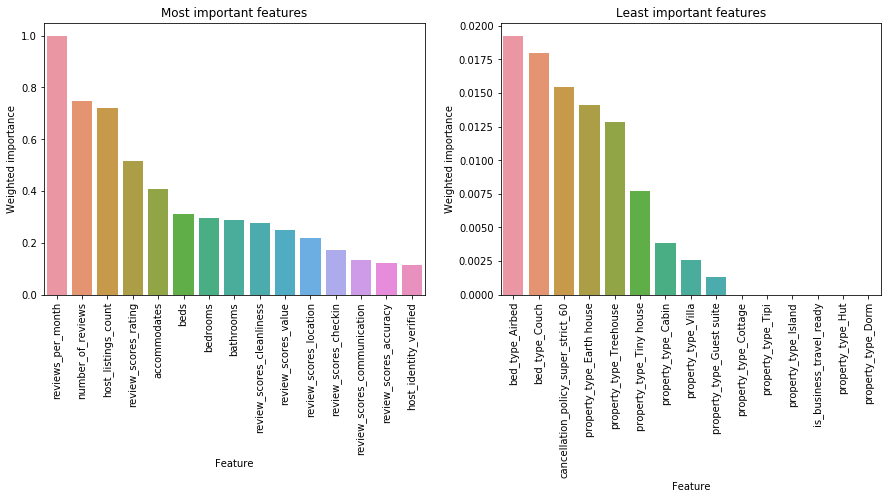

In [30]:
f, axs = plt.subplots(1,2,figsize=(15,5));

sns.barplot(x='feature', y='importances', data=feature_imps.head(15), ax=axs[0])
axs[0].set_title('Most important features')
axs[0].set_xlabel('Feature')
axs[0].set_ylabel('Weighted importance')

sns.barplot(x='feature', y='importances', data=feature_imps.tail(15), ax=axs[1])
axs[1].set_title('Least important features')
axs[1].set_xlabel('Feature')
axs[1].set_ylabel('Weighted importance');

for ax in axs:
    plt.sca(ax)
    plt.xticks(rotation=90)

#### Visualize to see how many data points should be included in the analysis

We will only include teh number of features required to gain total of 80% cumulative importance. We can see that it is achieved at around 35 features. 

Text(0,0.5,'Cumulative importance')

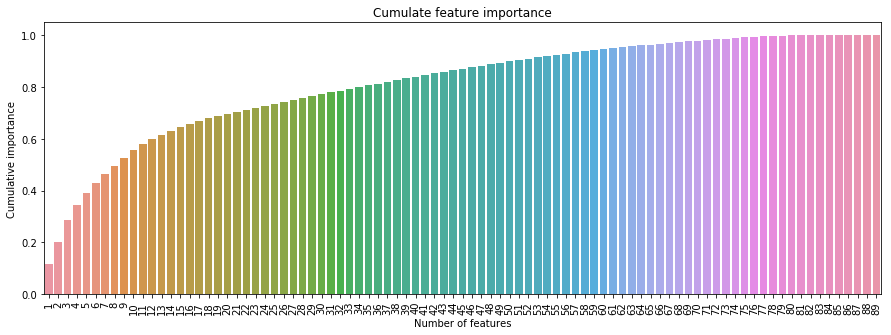

In [49]:
plt.figure(figsize=(15,5))
sns.barplot(x='no_features', y='cum_imp', data=feature_imps)
plt.xticks(rotation='vertical')
plt.title('Cumulate feature importance')
plt.xlabel('Number of features')
plt.ylabel('Cumulative importance')

#### Train the best model on reduce features and compare it to the best model on all features

Just something to compare and see if our model predicts well even with the reduced number of features. In our cases, we don't have as many features, we only have about 89 features so its not too bad. But if there are many feautures in the data, such a feature reduction can be useful. 

We can observe a drop about 0.9% in median absolute percentage error with reduce data points.

In [50]:
n_feature = 35

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:n_feature]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:n_feature]]]

# Train on the "best" model found from grid search earlier and 
reduced_model = (clone(best_estimator[best_key]))
reduced_model.fit(X_train_reduced, Y_train)

model_compare = {best_key:best_estimator[best_key],
                best_key+'_reduced':reduced_model}


# Print results
for key in model_compare:
    if key == best_key:
        mapd, mae, r2, pred_t, mae_log = calculate_eval_metrics(model_compare[key], 
                                                   X_test, Y_test)
    else:
        mapd, mae, r2, pred_t, mae_log = calculate_eval_metrics(model_compare[key], 
                                                   X_test_reduced, Y_test)
    
    print('Model: ', key)
    print('Median absolute percentage error:  {:0.4f}%'.format(mapd))
    print('Median absolute error:  {:0.4f}'.format(mae))
    print('r2 score:  {:0.4f}'.format(r2))
    print('Prediction time per 1000:  {:0.4f} seconds'.format(pred_t))
    print(' ')

Model:  xgboost
Median absolute percentage error:  20.8513%
Median absolute error:  20.2013
r2 score:  0.6651
Prediction time per 1000:  0.0224 seconds
 
Model:  xgboost_reduced
Median absolute percentage error:  21.7362%
Median absolute error:  20.8508
r2 score:  0.6425
Prediction time per 1000:  0.0245 seconds
 


# Conclusion



## Listing price prediciton

Here we built various regression models to predict the Airbnb listing price. Our best xgboost model had a median absolute percentage error of 20.85% with a r2 score of 0.6651.



## Future improvement

1. One critical insight missing in the data is the occupancy ratio for the listing. This data is not publicly available. But this insight would be very useful, as it gives us some idea of how the price is perceived by the market. If the listing price is low, it will have higher occupancy rate, and vice-versa. In current data, the only public perception on the pricing is from review_scores. Our model does give importance to those features, but it would be interesting to see if we can improve model performance with occupancy data. 

2. A wider grid search for regression model. As always, I could have further hypertuned the data transformation and estimator hyperparameter. But I only had so much of personal computational resources.